In [1]:
#DEEP-PHURIE: https://www.researchgate.net/publication/335081788_Deep-PHURIE_deep_learning_based_hurricane_intensity_estimation_from_infrared_satellite_imagery

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import model_selection   
from sklearn.model_selection import train_test_split
import pickle
print(tf.__version__)

2.10.0


In [2]:
data_path = "./TCIR-ALL_2017.h5"
data_info = pd.read_hdf(data_path, key="info", mode='r')
with h5py.File(data_path, 'r') as hf:
    data_matrix = hf['matrix'][:]

In [3]:
data_info

,data_set,ID,lon,lat,time,Vmax,R35_4qAVG,MSLP
0,ATLN,201701L,-50.3,35.8,2017041606,55.0,270.0,992.0
1,ATLN,201701L,-49.9,35.5,2017041609,55.0,270.0,990.0
2,ATLN,201701L,-49.5,35.1,2017041612,55.0,270.0,989.0
3,ATLN,201701L,-49.1,34.8,2017041615,55.0,262.5,988.0
4,ATLN,201701L,-48.7,34.4,2017041618,55.0,255.0,986.0
...,...,...,...,...,...,...,...,...
4575,WPAC,201733W,105.0,8.4,2017122600,20.0,0.0,1007.0
4576,WPAC,201733W,104.7,8.4,2017122603,20.0,0.0,1007.0
4577,WPAC,201733W,104.4,8.4,2017122606,20.0,0.0,1007.0
4578,WPAC,201733W,104.0,8.4,2017122609,18.0,0.0,1009.0


In [4]:
np.shape(data_matrix)
# print(data_matrix.columns)

(4580, 201, 201, 4)

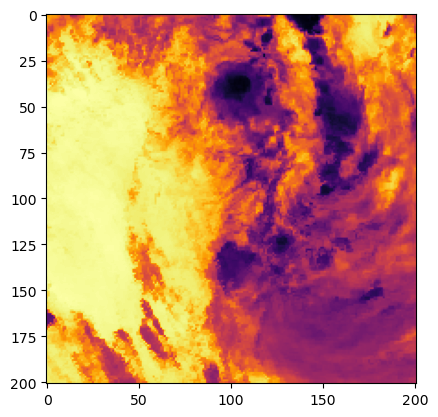

In [5]:
img = data_matrix[69,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.inferno)

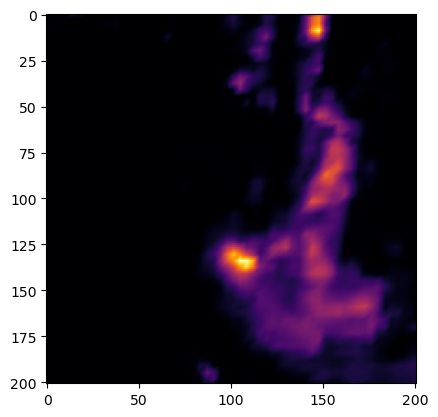

In [6]:
img = data_matrix[69,:,:,3].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.inferno)

In [7]:
data_info = data_info.assign(time=pd.to_datetime(data_info.time, format=r'%Y%m%d%H'))

In [8]:
## keep only IR and PMW
X_irpmw = data_matrix[:,:,:,0::3]
y = data_info['Vmax'].values[:,np.newaxis]

In [9]:
X_irpmw[np.isnan(X_irpmw)] = 0
X_irpmw[X_irpmw > 1000] = 0

In [10]:
train_x, test_x, train_y, test_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.2)

In [11]:
X_tensor = tf.convert_to_tensor(X_irpmw) 
y = tf.convert_to_tensor(y)

In [12]:
X_std = tf.image.per_image_standardization(X_tensor)

In [13]:
img = X_std[0,:,:,:]
print(np.mean(img), np.std(img))

-3.965676e-08 1.0


In [14]:
class Preprocessing(keras.layers.Layer):
    def __init__(self):
        super(Preprocessing, self).__init__()
    def call(self, inputs, training=None):
        if training:
            inputs = tf.image.rot90(inputs, k=np.random.randint(4))
        return tf.image.central_crop(inputs, 0.5)

In [15]:
pp = Preprocessing()

In [16]:
rotated = pp(X_std[:5,:,:,:], training=True)

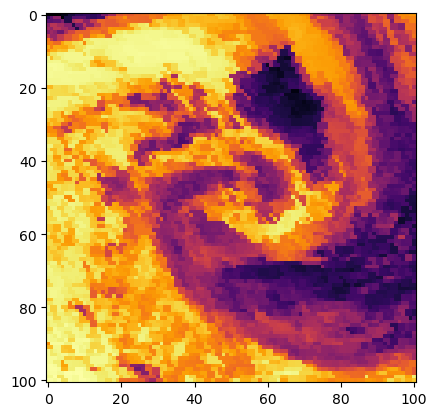

In [17]:
fig, ax = plt.subplots()
pos = ax.imshow(rotated[4,:,:,0], plt.cm.inferno)

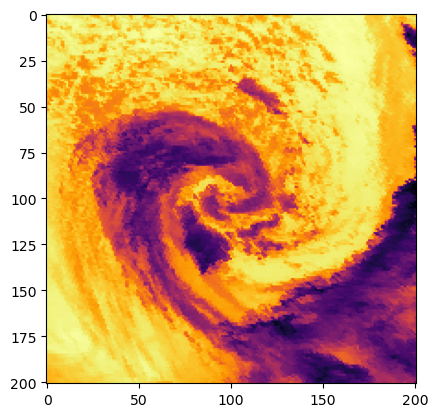

In [18]:
fig, ax = plt.subplots()
pos = ax.imshow(X_std[4,:,:,0], plt.cm.inferno)

# Alexnet Model Building & Testing

In [19]:
#A function that trains and validates the model and returns the MSE
def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    train_X = tf.image.per_image_standardization(train_X)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    val_X = tf.image.per_image_standardization(val_X)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(128, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(1, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    ])
    
    #Compiling the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error', #Computes the mean of squares of errors between labels and predictions
                  metrics=[['mean_squared_error']], #Computes the mean squared error between y_true and y_pred
                 )
    
    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1,
         validation_split=0.1,
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)

    return history,val_score

In [20]:
n_epochs=15
batch_size=64
model_history = []  #save the model history in a list after fitting so that we can plot later
val_scores=[]
kf = model_selection.KFold(n_splits=3)

i=0
for train_index, test_index in kf.split(X_irpmw):
    print("Training on Fold: ",i+1)
    i+=1
    tr = len(train_index)
    te = len(test_index)
    train_x = X_irpmw[train_index[0]:train_index[tr-1]]
    val_x = X_irpmw[test_index[0]:test_index[te-1]]
    train_y= y[train_index[0]:train_index[tr-1]]
    val_y = y[test_index[0]:test_index[te-1]]
    history,val_score = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
    model_history.append(history)
    val_scores.append(val_score)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/15


C:\Users\admin\anaconda3\envs\cyclone_env\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


43/43 [==============================] - 10s 208ms/step - loss: 1043.0728 - mean_squared_error: 1043.0665 - val_loss: 368.2254 - val_mean_squared_error: 368.2200
Epoch 2/15
43/43 [==============================] - 8s 177ms/step - loss: 519.7153 - mean_squared_error: 519.7105 - val_loss: 286.0712 - val_mean_squared_error: 286.0665
Epoch 3/15
43/43 [==============================] - 8s 176ms/step - loss: 411.9991 - mean_squared_error: 411.9945 - val_loss: 260.0824 - val_mean_squared_error: 260.0779
Epoch 4/15
43/43 [==============================] - 7s 158ms/step - loss: 379.5771 - mean_squared_error: 379.5726 - val_loss: 229.5377 - val_mean_squared_error: 229.5332
Epoch 5/15
43/43 [==============================] - 6s 146ms/step - loss: 370.4024 - mean_squared_error: 370.3979 - val_loss: 212.7671 - val_mean_squared_error: 212.7626
Epoch 6/15
43/43 [==============================] - 7s 172ms/step - loss: 368.1569 - mean_squared_error: 368.1523 - val_loss: 275.3617 - val_mean_squared_erro

48/48 [==============================] - 0s 6ms/step - loss: 429.4402 - mean_squared_error: 429.4343
Val Score:  [429.4402160644531, 429.4342956542969]




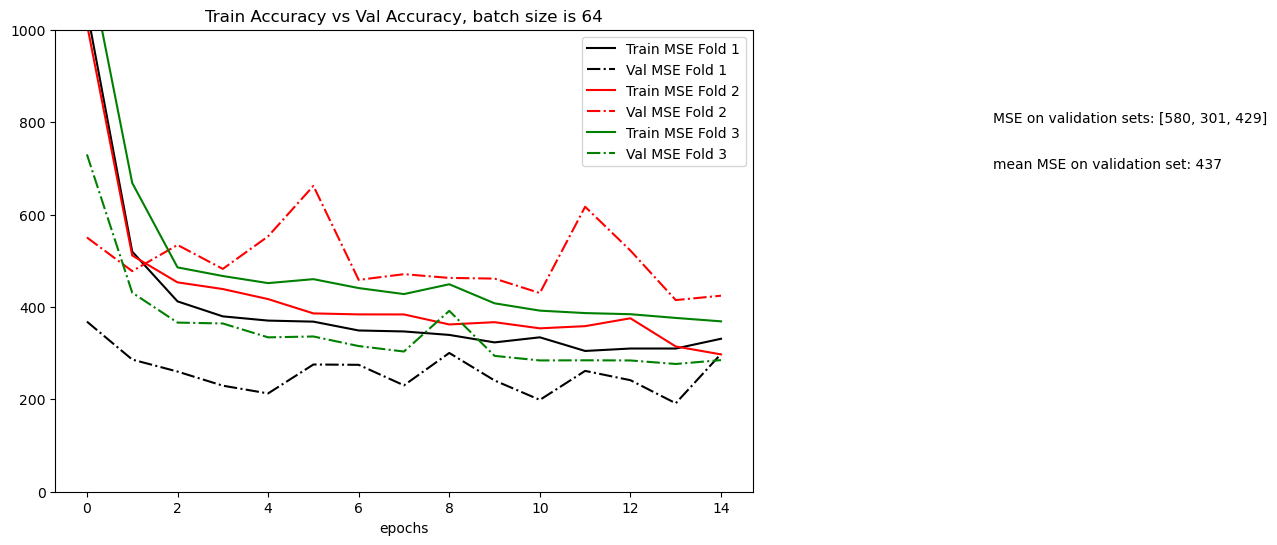

In [22]:
plt.figure(figsize=(9,6))
plt.title('Train Accuracy vs Val Accuracy, batch size is 64')
colors=['black','red','green','purple','orange']
for i in range(3):
    plt.plot(model_history[i].history['mean_squared_error'], label='Train MSE Fold '+str(i+1), color=colors[i])
    plt.plot(model_history[i].history['val_mean_squared_error'], label='Val MSE Fold '+str(i+1), color=colors[i], linestyle = "dashdot")

plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylim(0,1000)
plt.text(20,800,"MSE on validation sets: "+str([int(v) for v,v2 in val_scores]))
plt.text(20,700,"mean MSE on validation set: "+str(int(np.mean(val_scores,axis=0)[0])))
plt.show()

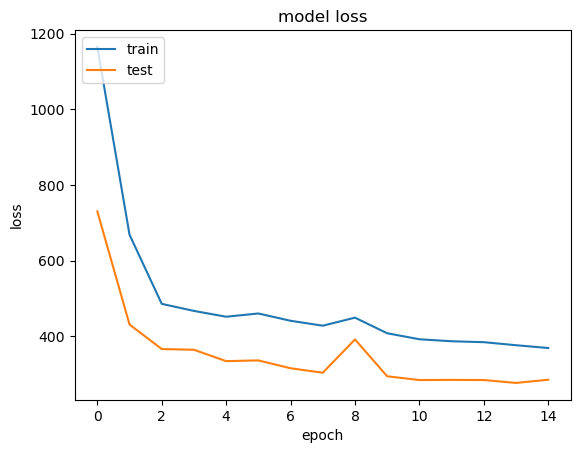

In [23]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Create a sequential deepPHURIE_model
deepPHURIE_model = Sequential()

# First Convolutional layer
deepPHURIE_model.add(Conv2D(32, kernel_size=(5, 5), input_shape=(224, 224, 3), activation='relu'))
deepPHURIE_model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))
deepPHURIE_model.add(BatchNormalization())

# 2 Convolutional layers
deepPHURIE_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
deepPHURIE_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
deepPHURIE_model.add(BatchNormalization())

# 3 Convolutional layers
deepPHURIE_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
deepPHURIE_model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
deepPHURIE_model.add(BatchNormalization())

# 4 Convolutional layers
deepPHURIE_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
deepPHURIE_model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
deepPHURIE_model.add(BatchNormalization())

# 5 Convolutional layers
deepPHURIE_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
deepPHURIE_model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
deepPHURIE_model.add(BatchNormalization())

# 6 Convolutional layers
deepPHURIE_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
deepPHURIE_model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
deepPHURIE_model.add(BatchNormalization())

# Flatten the output to feed into fully connected layers
deepPHURIE_model.add(Flatten())

# First fully connected layer
deepPHURIE_model.add(Dense(256, activation='relu'))
deepPHURIE_model.add(Dropout(0.5))  # Dropout for regularization
deepPHURIE_model.add(BatchNormalization())

# Second fully connected layer
deepPHURIE_model.add(Dense(128, activation='relu'))
deepPHURIE_model.add(Dropout(0.5))  # Dropout for regularization
deepPHURIE_model.add(BatchNormalization())

# Output layer
deepPHURIE_model.add(Dense(1, activation='linear'))  # Assuming the output is a single value for intensity prediction

# Compile the deepPHURIE_model
deepPHURIE_model.compile(optimizer='adam', loss='mean_squared_error')

# Display the deepPHURIE_model summary
deepPHURIE_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 108, 108, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 108, 108, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_13 (Conv2D)          (None, 106, 106, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 52, 52, 32)       0         
 2D)                                                             
                                                      

In [ ]:
#A function that trains and validates the model and returns the MSE
def deepPHURIE_model_train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size,model):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    train_X = tf.image.per_image_standardization(train_X)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    val_X = tf.image.per_image_standardization(val_X)
    
    # weights_initializer = keras.initializers.GlorotUniform()
    
    #Compiling the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error', #Computes the mean of squares of errors between labels and predictions
                  metrics=[['mean_squared_error']], #Computes the mean squared error between y_true and y_pred
                 )
    
    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1,
         validation_split=0.1,
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)

    return history,val_score

In [ ]:
n_epochs=15
batch_size=64
model_history = []  #save the model history in a list after fitting so that we can plot later
val_scores=[]
kf = model_selection.KFold(n_splits=3)

i=0
for train_index, test_index in kf.split(X_irpmw):
    print("Training on Fold: ",i+1)
    i+=1
    tr = len(train_index)
    te = len(test_index)
    train_x = X_irpmw[train_index[0]:train_index[tr-1]]
    val_x = X_irpmw[test_index[0]:test_index[te-1]]
    train_y= y[train_index[0]:train_index[tr-1]]
    val_y = y[test_index[0]:test_index[te-1]]
    history,val_score = deepPHURIE_model_train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size, deepPHURIE_model)
    model_history.append(history)
    val_scores.append(val_score)
    print("======="*12, end="\n\n\n")